# SpikeInterface v0.101.1 - Adapted by Rodrigo Noseda - October 2024

SpikeInterface to analyze a multichannel dataset from Cambridge Neurotech Probes. 
The dataset is extracted using open-ephys DAQ and Bonsai-rx (in .bin).
Event_timestamps need some work.

# 0. Preparation <a class="anchor" id="preparation"></a>

In [1]:
import spikeinterface.full as si
print(f"SpikeInterface Version: {si.__version__}")

SpikeInterface Version: 0.101.1


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import os
import glob

import warnings
warnings.simplefilter("ignore")
%matplotlib widget
#%matplotlib inline

# 1. Loading recording and probe information <a class="anchor" id="loading"></a>

In [3]:
# Setting file paths and basic parameters
base_folder = Path('D:/Ephys_C2DRG/')
data_folder = Path("D:/Ephys_C2DRG/2023_9_19/")
#Pasted directly from explorer "C:\Users\rodri\Documents\Bonsai-RN\Bonsai_DataRN\2023_3_21\"

recording_paths_list = []
for filename in os.listdir(data_folder):
    if filename.startswith('RawEphysData') and filename.endswith('.bin'):
        recording_paths_list.append(data_folder / filename)
print('Recording Files List:')
print(recording_paths_list)

# parameters associated to the bin format
num_channels = 64 #must know apriori; modify in probe below accordingly.
fs = 30000
gain_to_uV = 0.195
offset_to_uV = 0
rec_dtype = "float32"
time_axis = 0     
time_format = "%H:%M:%S.%f"

Recording Files List:
[WindowsPath('D:/Ephys_C2DRG/2023_9_19/RawEphysData_32Ch_ProbeF_Broken_0.bin'), WindowsPath('D:/Ephys_C2DRG/2023_9_19/RawEphysData_32Ch_ProbeF_Broken_1.bin')]


In [4]:
#Extract and append recording segments to Baserecording object
recordings_list = []
rec = si.read_binary(recording_paths_list, num_chan=num_channels,sampling_frequency=fs,
                           dtype=rec_dtype, gain_to_uV=gain_to_uV, offset_to_uV=offset_to_uV, 
                           time_axis=time_axis, is_filtered=False)
recordings_list.append(rec)#Appends all extracted rec to a list
#Appending segments of recordings (Better because concatenate breaks timeline!)
recording = si.append_recordings(recordings_list)#Creates Object AppendSegment
#print(recording)
for i in range(recording.get_num_segments()):
    s = recording.get_num_samples(segment_index=i)
    d = recording.get_duration(segment_index=i)
    t = recording.has_time_vector(segment_index=i)
    print(f"Segment {i}: Duration: {d} sec - Samples: {s} - Has time vector?: {t}")

Segment 0: Duration: 3600.064 sec - Samples: 108001920 - Has time vector?: False
Segment 1: Duration: 3070.896 sec - Samples: 92126880 - Has time vector?: False


In [5]:
#Load times from timestamps csv files and calculate start time in seconds.
tms_files = sorted(glob.glob(os.path.join(data_folder, "Timestamps*.csv")))
concatenated_start_times = pd.DataFrame()
for tms_file in tms_files:
    df = pd.read_csv(tms_file, header=None, nrows=1, names=['Start_Times'])#(usecols=[0], nrows=1)
    df['Start_Times'] = df['Start_Times'].str.slice(0, 15)#first = df.head(1) #last = df.tail(1)
    concatenated_start_times = pd.concat([concatenated_start_times, df], ignore_index=True)
concatenated_start_times['Start_Times'] = pd.to_datetime(concatenated_start_times['Start_Times'])
time_diff = concatenated_start_times['Start_Times'] - concatenated_start_times['Start_Times'].iloc[0]
seconds_start = time_diff.dt.total_seconds()

#Get and set time vector for recording segments
for i in range(recording.get_num_segments()):
    tms = recording.get_times(segment_index=i)
    tms_temp = tms + seconds_start[i]
    recording.set_times(tms_temp, segment_index=i, with_warning=True)
print(recording.has_time_vector(segment_index=0))
print(recording.get_times(segment_index=0))
print(recording.has_time_vector(segment_index=1))
print(recording.get_times(segment_index=1))

True
[0.00000000e+00 3.33333333e-05 6.66666667e-05 ... 3.60006390e+03
 3.60006393e+03 3.60006397e+03]
True
[3600.490496   3600.49052933 3600.49056267 ... 6671.386396   6671.38642933
 6671.38646267]


In [ ]:
#Load ttl times from csv files, calculate time in seconds, and create structured array ttl_events.
ttl_files = sorted(glob.glob(os.path.join(data_folder, "TTL*.csv")))
ttl_events = []
for ttl_file in ttl_files:
    df = pd.read_csv(ttl_file, header=None, usecols=[0], names=['TTL_Times'])#(usecols=[0], nrows=1)
    df['TTL_Times'] = df['TTL_Times'].str.slice(0, 15)#first = df.head(1) #last = df.tail(1)
    df['TTL_Times'] = pd.to_datetime(df['TTL_Times'])
    time_diff_ttl = df['TTL_Times'] - concatenated_start_times['Start_Times'].iloc[0]
    seconds_ttl = time_diff_ttl.dt.total_seconds()
    ttl_array = np.array(list(seconds_ttl), dtype=[('time', '<f8')])
    ttl_events.append(ttl_array)  
print(ttl_events)

In [ ]:
#Load Events from csv files, calculate time in seconds, and create structured array stim_events.
event_files = sorted(glob.glob(os.path.join(data_folder, "Events*.csv")))
stim_events = []
for event_file in event_files:
    df = pd.read_csv(event_file, header=None, usecols=[0, 1], names=['Stim_start', 'Stim_end'])#(usecols=[0], nrows=1)
    df['Stim_start'] = df['Stim_start'].str.slice(0, 15)#first = df.head(1) #last = df.tail(1)
    df['Stim_start'] = pd.to_datetime(df['Stim_start'])
    df['Stim_end'] = df['Stim_end'].str.slice(0, 15)
    df['Stim_end'] = pd.to_datetime(df['Stim_end'])
    time_diff_start = df['Stim_start'] - concatenated_start_times['Start_Times'].iloc[0]
    time_diff_end = df['Stim_end'] - concatenated_start_times['Start_Times'].iloc[0]
    seconds_stim_start = time_diff_start.dt.total_seconds()
    seconds_stim_end = time_diff_end.dt.total_seconds()
    stim_array = np.array(list(seconds_stim_start), dtype=[('time', '<f8')])
    stim_events.append(stim_array)
print(stim_events)

rec, sort = si.generate_ground_truth_recording()
rec.set_times(np.arange(rec.get_num_samples()) / rec.sampling_frequency + 100)
rec_slice = rec.frame_slice(start_frame=int(1 * rec.sampling_frequency), end_frame=int(2 * rec.sampling_frequency))
print(rec_slice.get_times()[:10])

ProbeInterface version: 0.2.24


(-60.0, 300.0)

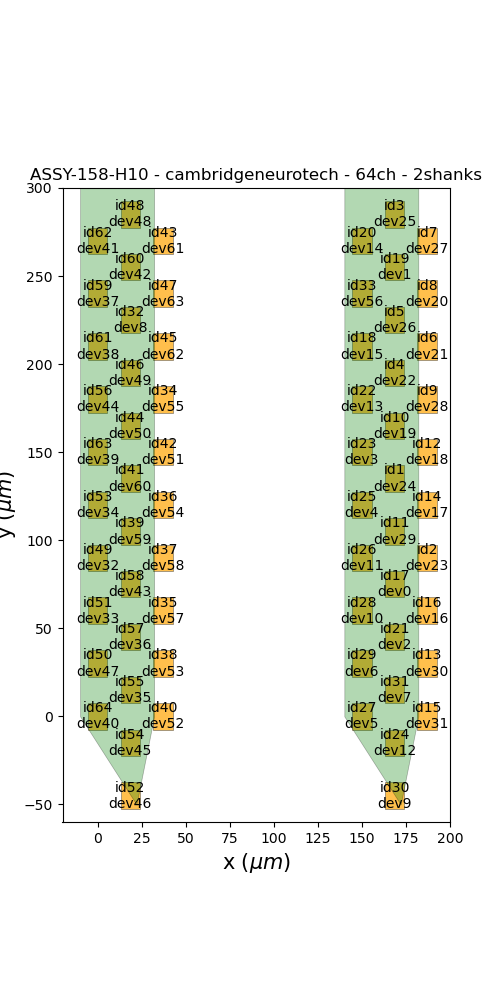

In [8]:
#Get probe from library and set channel mapping
import probeinterface as pi
from probeinterface.plotting import plot_probe
print(f"ProbeInterface version: {pi.__version__}")
manufacturer = 'cambridgeneurotech'
probe_name = 'ASSY-158-H10' #probe_name = 'ASSY-158-F' #probe_name = 'ASSY-158-H6'
probeH10 = pi.get_probe(manufacturer, probe_name)#library: comes with contact_ids and shank_ids info.

#Mapping Intan (device) channels
device_channel_indices = [24,23,25,22,26,21,27,20,28,19,29,18,30,17,31,16,0,15,1,14,2,13,3,12,4,11,5,10,6,9,7,8,
    56,55,57,54,58,53,59,52,60,51,61,50,62,49,63,48,32,47,33,46,34,45,35,44,36,43,37,42,38,41,39,40] #Modify accordingly.
#   88,87,89,86,90,85,91,84,92,83,93,82,94,81,95,80,64,79,65,78,66,77,67,76,68,75,69,74,70,73,71,72,
#   120,119,121,118,122,117,123,116,124,115,125,114,126,113,127,112,96,111,97,110,98,109,99,108,100,107,101,106,102,105,103,104]
#Setting Intan channels to probe(RHD-2132/2164)
probeH10.set_device_channel_indices(device_channel_indices) #print(probeH10.device_channel_indices)
fig, ax = plt.subplots(figsize=(5, 10))
plot_probe(probeH10, ax=ax, with_contact_id=True, with_device_index=True,)
ax.set_xlim(-20, 200)
ax.set_ylim(-60, 300)
#probeH10.to_dataframe(complete=True).loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]]

The probe now is loaded with contact_ids, device_ids and shank_id.
A probe (prb) or `probeinterface` object can be loaded directly to a SI recording object. A group can also be formed from each probe ('by_probe') or shank ('by_shank')

In [ ]:
recording_prb = recording.set_probe(probeH10, group_mode="by_probe")
channels_ids = recording_prb.get_channel_ids()
recording_slice = recording_prb.channel_slice(channel_ids=channels_ids[:3]) #channel_ids = list(range(0, 4))
si.plot_traces(recording_slice, segment_index=0, channel_ids=None,
                          time_range=(0, 2.25), mode='line', backend='ipywidgets', 
                          show_channel_ids= True, clim=None)

# 2. Preprocessing <a class="anchor" id="preprocessing"></a>

All preprocessing modules return new `RecordingExtractor` objects that apply the underlying preprocessing function. This allows users to access the preprocessed data in the same way as the raw data. We will focus only on the first shank (group `0`) for now.

In [ ]:
recordings_by_group = recording_prb.split_by("group")
recording_to_process = recordings_by_group[0]
recording_f = si.bandpass_filter(recording_to_process, freq_min=300, freq_max=6000)
recording_cmr = si.common_reference(recording_f, reference='global', operator='median')
recording_to_process

In [9]:
# Step 1: Load times from timestamps csv files
tms_files = sorted(glob.glob(os.path.join(data_folder, "Timestamps*.csv")))
concatenated_first_last = pd.DataFrame()
for tms_file in tms_files:
    df = pd.read_csv(tms_file, header=None, names=['Timestamps'])#(usecols=[0], nrows=1)
    df['Timestamps'] = df['Timestamps'].str.slice(0, 15)
    first = df.head(1)
    last = df.tail(1)
    concatenated_first_last = pd.concat([concatenated_first_last, first, last], ignore_index=True)
#print(concatenated_first_last)

# Step 2: Process TTLs from csv files
ttl_files = sorted(glob.glob(os.path.join(data_folder, "TTL*.csv")))
concatenated_df_ttl = pd.DataFrame()
for ttl_file in ttl_files:
    df = pd.read_csv(ttl_file, header=None, names=['Timestamps'])#(usecols=[0], nrows=1)
    df['Timestamps'] = df['Timestamps'].str.slice(0, 15)
    concatenated_df_ttl = pd.concat([concatenated_df_ttl, df], ignore_index=True)
#print(concatenated_df_ttl)

# Step 3: Process Events from csv files
events_files = sorted(glob.glob(os.path.join(data_folder, "Events*.csv")))
concatenated_df_events = pd.DataFrame()
for event_file in events_files:
    df = pd.read_csv(event_file, usecols=[0, 1], header=None, names=['Timestamps_Start', 'Timestamps_Stop'])
    df['Timestamps_Start'] = df['Timestamps_Start'].str.slice(0, 15)
    df['Timestamps_Stop'] = df['Timestamps_Stop'].str.slice(0, 15)
    concatenated_df_events = pd.concat([concatenated_df_events, df], ignore_index=True)
#print(concatenated_df_events)

In [10]:
# Step 4: Convert timestamps to datetime objects.
concatenated_first_last['Timestamps'] = pd.to_datetime(concatenated_first_last['Timestamps'])
concatenated_df_ttl['Timestamps'] = pd.to_datetime(concatenated_df_ttl['Timestamps'])
concatenated_df_events['Timestamps_Start'] = pd.to_datetime(concatenated_df_events['Timestamps_Start'])
concatenated_df_events['Timestamps_Stop'] = pd.to_datetime(concatenated_df_events['Timestamps_Stop'])

# Step 5: Calculate total seconds of ttl and events from start time.
time_diff = concatenated_df_ttl['Timestamps'] - concatenated_first_last.loc[0, 'Timestamps']
time_diff2 = concatenated_df_events['Timestamps_Start'] - concatenated_first_last.loc[0, 'Timestamps']
time_diff3 = concatenated_df_events['Timestamps_Stop'] - concatenated_first_last.loc[0, 'Timestamps']

seconds_ttl = time_diff.dt.total_seconds()
seconds_events_start = time_diff2.dt.total_seconds()
seconds_events_stop = time_diff3.dt.total_seconds()
#print(seconds_ttl, seconds_events_start, seconds_events_stop)

In [ ]:
# Step 6: Convert times in seconds to structured numpy arrays.
np.array(seconds_ttl)
def create_structured_array(seconds_ttl):
    dtype = np.dtype([('time', np.float64)])  # Structured dtype
    ttl_structured_array = np.zeros(len(seconds_ttl), dtype=dtype)
    ttl_structured_array['time'] = seconds_ttl
    return ttl_structured_array
ttl_structured_array = create_structured_array(seconds_ttl)  # Create structured array

# Display the result
print(ttl_structured_array)

In [ ]:
channel_ids = list(range(0, 1))
w = si.plot_traces({"filtered": recording_f, "common": recording_cmr}, mode='line',
                   segment_index=0, channel_ids=channel_ids, show_channel_ids=True, events=ttl_events,
                   time_range=[3000, 3001], backend='ipywidgets')

## Take only 5 min. for demo

Since we are going to spike sort the data, let's first cut out a 5-minute recording, to speed up computations.

We can easily do so with the `frame_slice()` function:

In [ ]:
recording_select = si.select_segment_recording(recording_cmr, segment_indices=0)
recording_sub = recording_select.frame_slice(start_frame=0*fs, end_frame=300*fs)
print(recording_sub)

# 3. Saving and loading SpikeInterface objects <a class="anchor" id="save-load"></a>

All operations in SpikeInterface are *lazy*, meaning that they are not performed if not needed. This is why the creation of our filter recording was almost instantaneous. However, to speed up further processing, we might want to **save** it to a file and perform those operations (eg. filters, CMR, etc.) at once. 

Note: you can use the si.set_global_job_kwargs() to set job_kwargs globally for the entire session!

In [35]:
n_cpus = os.cpu_count()
n_jobs = n_cpus# - 2 #n_jobs = -1 :equal to the number of cores.
job_kwargs = dict(n_jobs=n_jobs, chunk_duration="1s", progress_bar=True)
#global_job_kwargs = dict(n_jobs=n_jobs, chunk_duration="1s", progress_bar=True)
#si.set_global_job_kwargs(global_job_kwargs)

In [ ]:
if (data_folder / "preprocessed").is_dir():
    recording_saved = si.load_extractor(data_folder / "preprocessed")
else:
    recording_saved = recording_cmr.save(folder=data_folder / "preprocessed", **job_kwargs)
    
print(recording_saved)
print(f'Cached channels ids:\n {recording_saved.get_channel_ids()}')
print(f'Channel groups after caching:\n {recording_saved.get_channel_groups()}')

The `traces_cached_seg0.raw` contains the processed raw data, while the `.json` files include information on how to reload the binary file. The `provenance.json` includes the information of the recording before saving it to a binary file, and the `probe.json` represents the probe object. The `save` returns a new *cached* recording that has all the previously loaded information: 

After saving the SI object, we can easily load it back in a new session:

In [ ]:
recording_loaded = si.load_extractor(data_folder/"preprocessed")
print(f'Loaded channels ids: {recording_loaded.get_channel_ids()}')
print(f'Channel groups after loading: {recording_loaded.get_channel_groups()}')

We can double check that the traces are exactly the same as the `recording_saved` that we saved:

In [ ]:
fig, axs = plt.subplots(ncols=2)
w_saved = si.plot_timeseries(recording_saved, ax=axs[0])
w_loaded = si.plot_timeseries(recording_loaded, ax=axs[1])
axs[0].set_title("Saved")
axs[1].set_title("Loaded")

**IMPORTANT**: the same saving mechanisms are available also for all SortingExtractor

# 5. Spike sorting <a class="anchor" id="spike-sorting"></a>

We can now run spike sorting on the above recording. We will use different spike sorters for this demonstration, to show how easy SpikeInterface makes it easy to interchengably run different sorters :)

Let's first check the installed sorters in `SpikeInterface` to see if `tridesclous` is available. Then we can then check the `tridesclous` default parameters.
We will sort the bandpass cached filtered recording the `recording_saved` object.

In [ ]:
si.installed_sorters()

In [ ]:
from pprint import pprint
default_KS4_params = si.get_default_sorter_params('kilosort4')
# Parameters can be changed by single arguments: 
#default_KS4_params['Th_universal'] = 9
#sorter_params = {'do_correction': False} #??
pprint(default_KS4_params)

In [ ]:
si.run_sorter?

In [ ]:
#Run spike sorting on recording using docker container
sorting_KS4 = si.run_sorter('kilosort4', recording_sub, 
                            output_folder=data_folder / 'results_KS4',
                            docker_image=True, verbose=True)#, **sorter_params, **job_kwargs)

In [ ]:
sorting_KS4

In [ ]:
sorting_saved_KS4 = sorting_KS4.save(folder=data_folder / "sorting_KS4")

In [ ]:
sorting_loaded_KS4 = si.load_extractor(data_folder / "sorting_KS4")
sorting_loaded_KS4
#sorting_KS4 = si.read_sorter_folder(data_folder/"results_KS4")

We can use `spikewidgets` functions for some quick visualizations:

In [ ]:
w_rs = si.plot_rasters(sorting_KS4, time_range=(0, 300), backend='matplotlib')

# 6. Postprocessing: SortingAnalyzer <a class="anchor" id="sortinganalyzer"></a>

The core module uses `SortingAnalyzer` for postprocessing computation from paired recording-sorting objects. It retrieves waveforms, templates, spike amplitudes, etc.

In [ ]:
#sparsity = si.estimate_sparsity?
sparsity = si.estimate_sparsity(sorting_KS4,recording, num_spikes_for_sparsity=200, method="radius",
                                radius_um=40, peak_sign="both", amplitude_mode="extremum")
#sparsity2 = si.compute_sparsity(sorting_KS4,recording)
for unit_id in sparsity.unit_ids[::30]:
    print(unit_id, list(sparsity.unit_id_to_channel_ids[unit_id]))
#most of the plotting, computation and export functions are using 'sparsity' in the background.

In [ ]:
#si.create_sorting_analyzer?
sa = si.create_sorting_analyzer(sorting_KS4, recording_sub, folder=data_folder / "sorting_analyzer", 
                              format="binary_folder", sparsity=sparsity, overwrite=True, **job_kwargs)

In [ ]:
#Saving Analyzer in specific format and loading it from saved
#sa.save_as(format="zarr",folder=data_folder / "sorting_analyzer")
#sa_bin = si.load_sorting_analyzer(folder=data_folder / "sorting_analyzer")
#sa_zarr = si.load_sorting_analyzer(folder=data_folder / "sorting_analyzer.zarr")

#### Computing Extensions: PCA, waveforms, templates, spike amplitude, correlograms, etc.

Let's move on to explore the postprocessing capabilities of the `postprocessing` module. Similarly to the `SortingAnalizer` object, the method 'compute` retrieve info on demand.

In [ ]:
all_computable_extensions = sa.get_computable_extensions()
print(all_computable_extensions)

In [ ]:
#SortingAnalizer computations: each call will recompute and overwrite previous computations
rand = sa.compute("random_spikes", method="uniform", max_spikes_per_unit=500)#subsample to create a template
wf = sa.compute("waveforms", ms_before=1, ms_after=2, **job_kwargs)
templ =sa.compute("templates", operators=["average", "median", "std"])#from raw waveforms or random_spikes
spk_amp = sa.compute("spike_amplitudes", peak_sign="neg")#based on templates
noise = sa.compute("noise_levels")
amp_scal = sa.compute("amplitude_scalings")#per channel
pca = sa.compute("principal_components", n_components=3, mode="by_channel_local")
corr = sa.compute("correlograms", window_ms=50.0, bin_ms=1.0, method="auto")
isi = sa.compute("isi_histograms", window_ms=50.0, bin_ms=1.0, method="auto")
spk_loc = sa.compute("spike_locations", method="center_of_mass")#need for drift metrics (drift_ptp, drift_std, drift_mad)
templ_sim = sa.compute("template_similarity")#need for spikeinterface_gui
u_loc = sa.compute("unit_locations", method="monopolar_triangulation")
templ_metric = sa.compute("template_metrics")
qm = sa.compute("quality_metrics")
# qm = si.compute_quality_metrics(analyzer, metric_names=metric_names) #display(qm) #using 'si' gives a dataframe.
#sparsity3 = sa.compute("sparsity")

In [ ]:
wf_ext = sa.get_extension("waveforms")
wf0 = wf_ext.get_waveforms_one_unit(unit_id=0)
print(f"Waveform shape: {wf0.shape}")

templ_ext = sa.get_extension("templates")
templ0 = templ_ext.get_templates(operator="average")
print(type(templ0), templ0.shape)

Extensions are generally saved in two ways: 

sorting_analyzer = create_sorting_analyzer(sorting=sorting, recording=recording, format="memory")

sorting_analyzer.save_as(folder="my_sorting_analyzer")
sorting_analyzer.compute("random_spikes", save=True)

Here the random_spikes extension is not saved. The sorting_analyzer is still saved in memory. The save_as method only made a snapshot of the sorting analyzer which is saved in a folder. This is useful when trying out different parameters and initially setting up your pipeline. If we wanted to save the extension we should have started with a non-memory sorting analyzer:

sorting_analyzer = create_sorting_analyzer(sorting=sorting, recording=recording, format="binary_folder", folder="my_sorting_analyzer")
sorting_analyzer.compute("random_spikes", save=True)

NOTE: We recommend choosing a workflow and sticking with it. Either keep everything on disk or keep everything in memory until you’d like to save. A mixture can lead to unexpected behavior.

# 7. Quality Metrics <a class="anchor" id="qualitymetrics"></a>

#### Metrics for Spikes

In [ ]:
si.get_default_qm_params()
si.get_quality_metric_list()

In [45]:
#Amplitud cutoff (calculate the approximate fraction of missing spikes)
#Need "spike_amplitudes"
fraction_missing = si.compute_amplitude_cutoffs(sa, peak_sign="neg")

#Amplitud CV (coefficient of variation)
#Need "spike_amplitudes" or "amplitude_scalings" pre-computed.
amplitude_cv_median, amplitude_cv_range = si.compute_amplitude_cv_metrics(sa)
#dicts: unit ids as keys, and amplitude_cv metrics as values.

#Drift metrics
#Need "spike_locations"
drift_ptps, drift_stds, drift_mads = si.compute_drift_metrics(sa)
#dicts: unit ids as keys, and drifts metrics as values.

#Firing Range (outside of physiological range, might indicate noise contamination)
firing_range = si.compute_firing_ranges(sa)
#dict: unit IDs as keys, firing_range as values (in Hz).

#Firing Rate (average number of spikes/sec within the recording)
firing_rate = si.compute_firing_rates(sa)
#dict or floats: unit IDs as keys, firing rates across segments as values (in Hz).

#Inter-spike-interval (ISI) Violations (rate of refractory period violations)
isi_violations_ratio, isi_violations_count = si.compute_isi_violations(sa, isi_threshold_ms=1.0) 
#dicts: unit ids as keys, and isi ratio viol and number of viol as values.

#Presence Ratio (proportion of discrete time bins in which at least one spike occurred)
presence_ratio = si.compute_presence_ratios(sa)
#dict: unit IDs as keys, presence ratio (between 0 and 1) as values.
#Close or > 0.9 = complete units.
#Close to 0 = incompleteness (type II error) or highly selective firing pattern.

#Standard Deviation (SD) ratio
sd_ratio = si.compute_sd_ratio(sa, censored_period_ms=4.0)
#Close to 1 = unit from single neuron.

#Signal-to-noise ratio (SNR)
SNRs = si.compute_snrs(sa)
#dict: unit IDs as keys and their SNRs as values.
#High SNR = likely to correspond to a neuron. Low SNR = unit contaminated.

#Synchrony Metrics (characterize synchronous events within the same spike train and across different spike trains)
synchrony = si.compute_synchrony_metrics(sa, synchrony_sizes=(2, 4, 8))
#tuple of dicts with the synchrony metrics for each unit.

#### Metrics for Clusters

In [ ]:
si.get_quality_pca_metric_list()

In [ ]:
#Isolation Distance (distance from a cluster to the nearest other cluster)
iso_distance = si.pca_metrics.mahalanobis_metrics(all_pcs=all_pcs, all_labels=all_labels, this_unit_id=0)
#returns floats: iso_distance, l_ratio.

#Nearest Neighbor Metrics (evaluate unit quality)
si.pca_metrics.nearest_neighbors_metrics(all_pcs, all_labels, this_unit_id, max_spikes, n_neighbors)
#Calculate unit contamination based on NearestNeighbors search in PCA space.
si.pca_metrics.nearest_neighbors_isolation(sa)
#Calculate unit isolation based on NearestNeighbors search in PCA space.
si.pca_metrics.nearest_neighbors_noise_overlap(sa)
#Calculate unit noise overlap based on NearestNeighbors search in PCA space.

#D-prime (estimate the classification accuracy between two units)
d_prime = si.lda_metrics(all_pcs=all_pcs, all_labels=all_labels, this_unit_id=0)
#returns a float (larger in well separated clusters)

#Silhouette score (ratio between the cohesiveness of a cluster and its separation from other clusters)
simple_sil_score = si.simplified_silhouette_score(all_pcs=all_pcs, all_labels=all_labels, this_unit_id=0)
#Close to 1 = good clustering. Close to -1 = poorly isolated cluster.

A straightforward way to filter a pandas dataframe is via the `query`.
We first define our query (make sure the names match the column names of the dataframe):
and then we can use the query to select units:

In [ ]:
#Automatic curation based on parameters
isi_viol_thresh = 0.5
amp_cutoff_thresh = 0.1

our_query = f"amplitude_cutoff < {amp_cutoff_thresh} & isi_violations_ratio < {isi_viol_thresh}"
print(our_query)

keep_units = df.query(our_query)
keep_unit_ids = keep_units.index.values
keep_unit_ids

In [ ]:
sorting_auto_KS4 = sorting_KS4.select_units(keep_unit_ids)
print(f"Number of units before curation: {len(sorting_KS4.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto_KS4.get_unit_ids())}")

In [ ]:
sa_curated = sa.select_units(keep_unit_ids)

#Saving Analyzer in specific format and loading it from saved
sa_curated_saved = sa_curated.save_as(format="zarr", folder=data_folder / "sorting_analyzer_curated.zarr")
print(sa_curated_saved)

# 8. Viewers <a class="anchor" id="viewers"></a>
### SpikeInterface GUI
Can be run directly in a terminal with: 
sigui /path/to/analyzer

In [ ]:
%gui qt
si.plot_sorting_summary(sorting_analyzer=sa, curation=True, backend='spikeinterface_gui')

In [ ]:
# Step 1: Load times from timestamps csv files
tms_files = sorted(glob.glob(os.path.join(data_folder, "Timestamps*.csv")))
concatenated_first_last = pd.DataFrame()
for tms_file in tms_files:
    df = pd.read_csv(tms_file, header=None, names=['Timestamps'])#(usecols=[0], nrows=1)
    df['Timestamps'] = df['Timestamps'].str.slice(0, 15)
    first = df.head(1)
    last = df.tail(1)
    concatenated_first_last = pd.concat([concatenated_first_last, first, last], ignore_index=True)
#print(concatenated_first_last)

# Step 2: Process TTLs from csv files
ttl_files = sorted(glob.glob(os.path.join(data_folder, "TTL*.csv")))
concatenated_df_ttl = pd.DataFrame()
for ttl_file in ttl_files:
    df = pd.read_csv(ttl_file, header=None, names=['Timestamps'])#(usecols=[0], nrows=1)
    df['Timestamps'] = df['Timestamps'].str.slice(0, 15)
    concatenated_df_ttl = pd.concat([concatenated_df_ttl, df], ignore_index=True)
#print(concatenated_df_ttl)

# Step 3: Process Events from csv files
events_files = sorted(glob.glob(os.path.join(data_folder, "Events*.csv")))
concatenated_df_events = pd.DataFrame()
for event_file in events_files:
    df = pd.read_csv(event_file, usecols=[0, 1], header=None, names=['Timestamps_Start', 'Timestamps_Stop'])
    df['Timestamps_Start'] = df['Timestamps_Start'].str.slice(0, 15)
    df['Timestamps_Stop'] = df['Timestamps_Stop'].str.slice(0, 15)
    concatenated_df_events = pd.concat([concatenated_df_events, df], ignore_index=True)
#print(concatenated_df_events)

In [ ]:
templates = si.plot_unit_templates(sa, backend="ipywidgets")#templ
waveforms = si.plot_unit_waveforms(sa, backend="ipywidgets")#wf
unit_locations = si.plot_unit_locations(sa, backend="ipywidgets")#u_loc
spk_locations = si.plot_spike_locations(sa, backend="ipywidgets")#spk_loc
spk_amplitude = si.plot_amplitudes(sa, backend="ipywidgets")#spk_amp
template_similarity = si.plot_template_similarity(sa)#, backend="ipywidgets")#templ_sim
autocorr = si.plot_autocorrelograms(sa, unit_ids=sorting_KS4.unit_ids[::10])#, backend="ipywidgets")#corr
crosscorr = si.plot_crosscorrelograms(sa, unit_ids=sorting_KS4.unit_ids[::10])#, backend="ipywidgets")#corr

### SortingView
Web-based, shareable (with link), sorter visualizer.

In [ ]:
sv = si.plot_sorting_summary(sa_curated, curation=True, backend='sortingview')

# 9. Exporters <a class="anchor" id="exporters"></a>
#### Export to Phy for manual curation [Phy](https://github.com/cortex-lab/phy). 

In [ ]:
si.export_to_phy(sa, output_folder=data_folder / 'phy_KS4_RN', compute_pc_features=True,
                   copy_binary=True, dtype='float32', compute_amplitudes=True,
                   sparsity=sparsity, add_quality_metrics=True, add_template_metrics=True, 
                   template_mode='median', verbose=True,**job_kwargs)

In [ ]:
#%%capture --no-display
!phy template-gui phy_KS4_RN/params.py

After curating the results we can reload it using the `PhySortingExtractor` and exclude the units that we labeled as `noise`:

In [ ]:
sorting_phy_curated = si.read_phy(data_folder / 'phy_KS4_RN/', exclude_cluster_groups=['noise'])
print(f"Number of units before curation: {len(sorting_KS4.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_phy_curated.get_unit_ids())}")
#Save the loaded curated phy into Spikeinterface object!!
#si.export_report(sa)